## <font color=red> Temporary header </font>

In [1]:
%load_ext autoreload
%autoreload 2

# Short Text Clustering

The following work is mainly inspired by:
- 2014 - Convolutional Neural Networks for Sentence Classification
- 2014 - A Convolutional Neural Network for Modelling Sentences
- 2017 - Self-Taught Convolutional Neural Networks for Short Text Clustering

Word embedding from fasttext are distributed under the license:
- Creative Commons Attribution-Share-Alike License 3.0 (free commercial use)

# Import

In [2]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt

src_emb = "./embeddings/"
src_stc = "./data/short_texts/"

In [3]:
# Dataset for short text clustering
os.listdir(src_stc)

['SearchSnippets_gnd.txt',
 'Biomedical_gnd.txt',
 'StackOverflow.txt',
 'StackOverflow_gnd.txt',
 'Biomedical.txt',
 'labels.tsv',
 'SearchSnippets.txt']

In [4]:
# Word embedding 
os.listdir(src_emb)

['glove100K.100d.vec', 'fasttext.wiki.en.vec']

# Fetching the data

#### Loading pre-trained Glove word embedding

The file `glove100K.100d.txt` is an extract of [Glove](http://nlp.stanford.edu/projects/glove/) Vectors, that were trained on english Wikipedia 2014 + Gigaword 5 (6B tokens).

We extracted the `100 000` most frequent words. They have a dimension of `100`

In [5]:
"""
%%time

glove_embeddings_index = {}
glove_embeddings_vectors = []

with open(src_emb + 'glove100K.100d.vec', 'rb') as f:
    word_idx = 0
    for line in tqdm_notebook(f, total=100000):
        values = line.decode('utf-8').split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings_index[word] = word_idx
        glove_embeddings_vectors.append(vector)
        word_idx = word_idx + 1

glove_inv_index = {v: k for k, v in glove_embeddings_index.items()}
print("found %d different words in the file" % word_idx) # Fetching word embedding from the web
"""
print("Glove desactivated")

Glove desactivated


#### Loading pre-trained Fasttext word embedding

Pre-trained word vectors for french languages, trained on Wikipedia using fastText. These vectors in dimension `300` were obtained using the skip-gram model described in `Bojanowski et al.(2016)` with default parameters.

We extracted the `100 000` most frequent words. They have a dimension of `300`

In [6]:
%%time

fast_embeddings_index = dict()
fast_embeddings_vectors = list()
total = 1 * int(1e5)

tmp_emb = list()

with open(src_emb + 'fasttext.wiki.en.vec', 'rb') as f:
    head = f.readline().decode('utf-8')
    for word_idx in tqdm_notebook(range(total), total=total):
        raw = f.readline().decode('utf-8').rstrip(' \n')
        tmp_emb.append(raw + ' \n')
        line = raw.split(' ')
        word = line[0]
        vector = np.asarray(line[1:], dtype='float32')
        fast_embeddings_index[word] = word_idx
        fast_embeddings_vectors.append(vector)
        
fast_inv_index = {v: k for k, v in fast_embeddings_index.items()}
print("found %d different words in the file" % total)

Widget Javascript not detected.  It may not be installed or enabled properly.



found 100000 different words in the file
CPU times: user 9.05 s, sys: 914 ms, total: 9.96 s
Wall time: 9.56 s


In [7]:
# Storing each embedding model
embedding_model = {}
embedding_model['fasttext'] = [fast_embeddings_index, fast_embeddings_vectors, fast_inv_index]
#embedding_model['glove'] = [glove_embeddings_index, glove_embeddings_vectors, glove_inv_index]

# Word embedding

In [8]:
#embedding_name = 'glove'
embedding_name = 'fasttext'
embeddings_index, embeddings_vectors, inv_index = embedding_model[embedding_name]

In [9]:
# Stack all embeddings in a large numpy array
embeddings = np.vstack(embeddings_vectors)
norms = np.linalg.norm(embeddings, axis=-1, keepdims=True)
embeddings_normed = embeddings / norms
print(embeddings.shape)

(100000, 300)


In [10]:
emb_shape = np.shape(embeddings[0])

def zeros_init():
    return np.zeros(shape=emb_shape)

def get_emb(word):
    idx = embeddings_index.get(word)
    if idx is None:
        return zeros_init()
    else:
        return embeddings[idx]

def get_normed_emb(word):
    idx = embeddings_index.get(word)
    if idx is None:
        return zeros_init()
    else:
        return embeddings_normed[idx]

In [11]:
epsilon = 1e-5

def most_similar(words, topn=10):
    query_emb = 0
    # If we have a list of words instead of one word
    if type(words) == list:
        for word in words:
            query_emb += get_emb(word)       
    else:
        query_emb = get_emb(words)
        
    query_emb = query_emb / (np.linalg.norm(query_emb) + epsilon)
    
    # Large numpy vector with all cosine similarities
    # between emb and all other words
    cosines = np.dot(embeddings_normed, query_emb)
    
    # topn most similar indexes corresponding to cosines
    idxs = np.argsort(cosines)[::-1][:topn]
    
    # pretty return with word and similarity
    return [(inv_index[idx], cosines[idx]) for idx in idxs]

In [12]:
most_similar('maths')

[('maths', 0.99999779),
 ('mathematics', 0.70726186),
 ('math', 0.70355946),
 ('gcse', 0.66205692),
 ('gcses', 0.60882723),
 ('igcse', 0.57441121),
 ('homework', 0.56958699),
 ('numeracy', 0.56879789),
 ('arithmetic', 0.54979843),
 ('physics', 0.54030263)]

In [13]:
most_similar('napoleon')

[('napoleon', 0.99999756),
 ('bonaparte', 0.77908337),
 ('napoléon', 0.71624571),
 ('napoleonic', 0.69677258),
 ('davout', 0.66151649),
 ('austerlitz', 0.6409688),
 ('masséna', 0.63768834),
 ('beauharnais', 0.63125008),
 ('soult', 0.62394291),
 ('talleyrand', 0.61470497)]

# Data exploration

#### Loading data

In [14]:
#data_name = "Biomedical"
data_name = "StackOverflow"

with open(src_stc + '%s.txt' % data_name, encoding="utf-8") as f:
    data = f.readlines()
data = [text.rstrip('\n') for text in data]

with open(src_stc + '%s_gnd.txt' % data_name, encoding="utf-8") as f:
    target = f.readlines()
target = [int(label.rstrip('\n')) for label in target]
    
print("short texts")
n_max = 10
__ = [print("%d --" %label, txt) for txt, label in zip(data[:n_max], target[:n_max])]
print("\n Total: %s texts" % format(len(data), ","))

short texts
18 -- How do I fill a DataSet or a DataTable from a LINQ query resultset ?
18 -- How do you page a collection with LINQ?
3 -- Best Subversion clients for Windows Vista (64bit)
3 -- Best Practice: Collaborative Environment, Bin Directory, SVN
7 -- Visual Studio Setup Project - Per User Registry Settings
18 -- How do I most elegantly express left join with aggregate SQL as LINQ query
7 -- .Net XML comment into API Documentation
15 -- Modify Address Bar URL in AJAX App to Match Current State
7 -- Integrating Visual Studio Test Project with Cruise Control
10 -- What should a longtime Windows user know when starting to use Linux?

 Total: 20,000 texts


In [15]:
# Random sample 

n = len(data)
sample = 2000
print("Loading %s samples" % format(sample, ","))
index_sample = np.random.randint(0, n, sample)

data = [data[idx] for idx in index_sample]
target = [target[idx] for idx in index_sample]

Loading 2,000 samples


In [16]:
most_similar('stackoverflow')

[('hemophilia', 0.0),
 ('penney', 0.0),
 ('leconte', 0.0),
 ('remodelled', 0.0),
 ('bdsm', 0.0),
 ('cité', 0.0),
 ('newry', 0.0),
 ('camberwell', 0.0),
 ('lightfoot', 0.0),
 ('outburst', 0.0)]

#### Splitting dataset into train-test

In [17]:
from sklearn.model_selection import train_test_split

# train test split of dataset
train, test, y_train, y_test = train_test_split(data, target, test_size=0.1, random_state=42)
print("train size: %d" % len(train))
print("test size: %d" % len(test))

train size: 1800
test size: 200


In [18]:
from keras.preprocessing.text import Tokenizer

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts(train)
sequences_train = tokenizer.texts_to_sequences(train)
sequences_test = tokenizer.texts_to_sequences(test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

MAX_NB_WORDS = len(word_index)

Using TensorFlow backend.


Found 3020 unique tokens.


#### Let's look at the length of the data

average length: 8.4
max length: 34


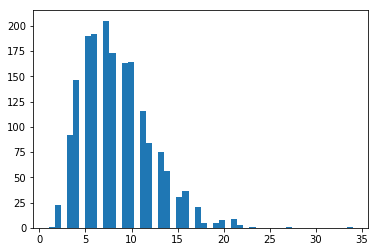

In [19]:
seq_lens = [len(s) for s in sequences_train]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))
plt.hist(seq_lens, bins=50);

In [20]:
from keras.preprocessing.sequence import pad_sequences

# according to previous cell
MAX_SEQUENCE_LENGTH = max(seq_lens)

# pad sequences with 0s
X_train = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', np.shape(X_train))
print('Shape of data test tensor:', np.shape(X_test))

Shape of data tensor: (1800, 34)
Shape of data test tensor: (200, 34)


In [21]:
from keras.utils.np_utils import to_categorical

Y_train = to_categorical(np.asarray(y_train))
Y_test = to_categorical(np.asarray(y_test))
print('Shape of label tensor:', Y_train.shape)
print('Shape of label tensor:', Y_test.shape)

Shape of label tensor: (1800, 21)
Shape of label tensor: (200, 21)


In [22]:
# creating embedding matrix

EMBEDDING_DIM = emb_shape[0]
N_CLASSES = 21

# prepare embedding matrix
nb_words_in_matrix = 0
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = get_emb(word)
    embedding_matrix[i] = embedding_vector
    nb_words_in_matrix = nb_words_in_matrix + 1
        
print("added %d words in the embedding matrix" % nb_words_in_matrix)

added 3020 words in the embedding matrix


# CNN

In [23]:

# Note, on this type of task, this technique will 
# degrade results as we train much less parameters
# and we average a large number pre-trained embeddings.
# You will notice much less overfitting then!
# Using convolutions / LSTM will help
# It is also advisable to treat seperately pre-trained
# embeddings and words out of vocabulary.

# Deep feature representations learning

## Target vectors

In [24]:
""" Be careful, dataset was shuffled during train-test split. """
# sequences
n_train = len(sequences_train)
n_test = len(sequences_test)
sequences = sequences_train + sequences_test
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
Y = dict()

# tf-idf
tfidf = tokenizer.sequences_to_matrix(sequences, mode='tfidf')

# label
y = y_train + y_test

# dictionary of reduction methods' name
reduction_methods = {"le": "laplacian eigenvalues",
                     "ae": "average embeddings",
                     "lsa": "latent semantic analysis"}

#### Average embeddings (AE)

``
%%time
denom = 1 + np.sum(tfidf, axis=1)[:, None]
normed_tfidf = tfidf/denom
average_embeddings = np.dot(normed_tfidf, embedding_matrix)
Y["ae"] = average_embeddings
print("Shape of average embedding: ", Y['ae'].shape)
``

#### Latent Semantic Analysis (LSA)

In [25]:
from sklearn.pipeline import  make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# self coded package
from utils.target import laplacian_eigenmaps, binarize

In [26]:
%%time
svd = TruncatedSVD(100)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
L = lsa.fit_transform(tfidf)
Y["lsa"] = L
print("Shape of latent semantic vectors: ", Y['lsa'].shape)

Shape of latent semantic vectors:  (2000, 100)
CPU times: user 3.76 s, sys: 141 ms, total: 3.9 s
Wall time: 270 ms


#### Laplacian Eigenmaps (LE) [memory intensive]

In [27]:
%%time

# eigen vectors from graph of text similarity
E = laplacian_eigenmaps(L, n_neighbors=15, subdim=15, n_jobs=-1)
Y["le"] = E

Fitting nearest neighbors
Creation of affinity matrix
Creation of heat kernel affinity matrix
Spectral embedding
CPU times: user 10.2 s, sys: 196 ms, total: 10.4 s
Wall time: 1.22 s


In [28]:
print(E.shape)
print()
print(E[0])

(2000, 15)

[-0.05336321 -0.03513588 -0.11873783  0.43252584  0.03657593 -0.0099068
 -0.05944819  0.01623772 -0.0090964   0.03882697  0.01372496 -0.01453695
 -0.01315077 -0.00685189  0.00919557]


#### Target vector: binary feature

In [29]:
reduction_name = "le"
B = binarize(Y[reduction_name])

# Last dimension in the CNN
LAST_DIMENSION = B.shape[1]

In [30]:
print(B.shape)
print()
print(B[0])

(2000, 15)

[ 0.  0.  0.  1.  1.  0.  0.  1.  0.  1.  1.  0.  0.  1.  1.]


In [31]:
B_train = B[:n_train]
B_test = B[n_train:]

# CNN for deep feature representation learning 

Remarks:
- Two layers is better
- Activation tanh slightly better than relu
- Setting trainable layer to "True", we achieved in 10 epochs with batch=50 a very good performance (0.32 with current architecture)

To try:
- Use multiple layers

In [32]:
from keras.layers import Input, Embedding, Flatten, Reshape
from keras.layers import Dense, Conv1D, Dropout, merge
from keras.layers import GlobalAveragePooling1D, AveragePooling1D
from keras.layers import MaxPooling1D, GlobalMaxPooling1D, ZeroPadding1D
from keras.models import Model
from sklearn.metrics import accuracy_score

In [33]:
embedding_matrix_copy = embedding_matrix.copy()
trainable_embedding = False

# Embedding layer
pretrained_embedding_layer = Embedding(
    input_dim=MAX_NB_WORDS+1,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
)

# Input
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = pretrained_embedding_layer(sequence_input)

# 1st Layer
x = Conv1D(200, 5, activation='tanh', border_mode='same')(embedded_sequences)
x = GlobalMaxPooling1D()(x)

# Output
x = Dropout(0.5)(x)
predictions = Dense(LAST_DIMENSION, activation='sigmoid')(x)
model = Model(sequence_input, predictions)

# Fine-tune embeddings or not
model.layers[1].trainable=trainable_embedding

# Model hyper-parameters
losses = {'bc': 'binary_crossentropy',
          'cc': 'categorical_crossentropy',
          'mse': 'mse',
          'mae': 'mae',
         }

# Loss and Optimizer
loss_name = 'bc'
model.compile(loss=losses[loss_name],
              optimizer='adam',
              metrics=['mae'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 34)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 34, 300)           906300    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 34, 200)           300200    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                3015      
Total params: 1,209,515
Trainable params: 303,215
Non-trainable params: 906,300
______________________________________________________________

/apps/anaconda/anaconda3/envs/willau/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(200, 5, activation="tanh", padding="same")`


In [34]:
%%time
nb_epoch = 5
model.fit(X, B, validation_split=0.2,
          epochs=nb_epoch, batch_size=100, verbose=2)

Train on 1600 samples, validate on 400 samples
Epoch 1/5
0s - loss: 0.6529 - mean_absolute_error: 0.4714 - val_loss: 0.6061 - val_mean_absolute_error: 0.4458
Epoch 2/5
0s - loss: 0.5710 - mean_absolute_error: 0.4200 - val_loss: 0.5437 - val_mean_absolute_error: 0.4030
Epoch 3/5
0s - loss: 0.5099 - mean_absolute_error: 0.3773 - val_loss: 0.5023 - val_mean_absolute_error: 0.3711
Epoch 4/5
0s - loss: 0.4673 - mean_absolute_error: 0.3461 - val_loss: 0.4748 - val_mean_absolute_error: 0.3481
Epoch 5/5
0s - loss: 0.4345 - mean_absolute_error: 0.3214 - val_loss: 0.4532 - val_mean_absolute_error: 0.3303
CPU times: user 31.2 s, sys: 4.28 s, total: 35.5 s
Wall time: 3.71 s


#### Deep feature representations h

In [35]:
from keras.models import Model

# take the penultimate layer
input = model.layers[0].input
output = model.layers[-2].output

# Take the output of the layer just before the AveragePooling2D
model_h = Model(input, output)

In [36]:
%%time
H = model_h.predict(X)

CPU times: user 2.34 s, sys: 349 ms, total: 2.69 s
Wall time: 279 ms


In [37]:
print("Sample shape: {}".format(H.shape))

Sample shape: (2000, 200)


# Tools for evaluating cluster quality

In [38]:
from sklearn.preprocessing import normalize
from collections import Counter
from operator import itemgetter

def map_label(true_labels, pred_labels):
    label_pair = list(zip(pred_labels, true_labels))
    count = tuple(Counter(label_pair).items())
    mapping = dict()
    n_label = len(np.unique(true_labels))
    
    # Get most likely mapping based on counts
    for label in range(n_label):
        tuples = [tup for tup in count if tup[0][0] == label]
        likely_tuple = max(tuples, key=itemgetter(1))[0]
        mapping[likely_tuple[0]] = likely_tuple[1]

    pred_labels_mapped = [mapping[x] for x in pred_labels]
    return pred_labels_mapped

def cluster_quality(true_labels, pred_labels):    
    h, c, v = metrics.homogeneity_completeness_v_measure(true_labels, pred_labels)
    nmi = metrics.normalized_mutual_info_score(true_labels, pred_labels)
    rand = metrics.adjusted_rand_score(true_labels, pred_labels)
    print("Homogeneity: %0.3f" % h)
    print("Completeness: %0.3f" % c)
    print("V-measure: %0.3f" % v)
    print("NMI: %0.3f" % nmi)
    print("Rand: %0.3f" % rand)
    pred_labels_mapped = map_label(true_labels, pred_labels)
    acc = accuracy_score(true_labels, pred_labels_mapped)
    print("Acc: %0.3f" % acc)

# K-means on deep feature representations

In [39]:
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
from sklearn.decomposition import PCA

# normalize deep feature representation
V = normalize(H, norm='l2')

In [40]:
%%time
#km = MiniBatchKMeans(n_clusters=20, init_size=1000, batch_size=1000, n_init=1)
km = KMeans(n_clusters=20, n_init=1)
km.fit(V)
pred_labels = km.labels_
true_labels = y

# Evaluate clustering
cluster_quality(true_labels, pred_labels)

Homogeneity: 0.634
Completeness: 0.646
V-measure: 0.640
NMI: 0.640
Rand: 0.475
Acc: 0.672
CPU times: user 899 ms, sys: 23 ms, total: 922 ms
Wall time: 64.7 ms


In [41]:
# parameters of deep feature representation learning
print("Deep feature learning parameters \n")

print("Number of epochs: %s" % nb_epoch)
print("Reduction name: %s" % reduction_methods[reduction_name])
print("Trainable word embedding layer: %s" % str(trainable_embedding))

Deep feature learning parameters 

Number of epochs: 5
Reduction name: laplacian eigenvalues
Trainable word embedding layer: False


# K-means on LSA

In [42]:
from sklearn.decomposition import TruncatedSVD

In [43]:
%%time
svd = TruncatedSVD(n_components=100)
LSA = svd.fit_transform(tfidf)
LSA = normalize(LSA)
print(LSA.shape)

(2000, 100)
CPU times: user 3.39 s, sys: 60 ms, total: 3.45 s
Wall time: 217 ms


In [44]:
%%time

km = KMeans(n_clusters=20, n_init=1)
km.fit(LSA)
pred_labels = km.labels_
true_labels = y

# Evaluate clustering
cluster_quality(true_labels, pred_labels)

Homogeneity: 0.602
Completeness: 0.644
V-measure: 0.622
NMI: 0.623
Rand: 0.385
Acc: 0.639
CPU times: user 707 ms, sys: 15 ms, total: 722 ms
Wall time: 45.1 ms


# Cluster visualization

In [45]:
%matplotlib inline
from matplotlib import pyplot as plt
from webcolors import name_to_rgb
from sklearn.manifold import TSNE

color_names = ['SeaGreen', 'Sienna', 'Silver', 'Navy', 'Purple', 'SlateGrey', 'Orange',
               'SpringGreen', 'SteelBlue', 'Lime', 'Teal', 'Thistle', 'Tomato', 'Turquoise',
               'Violet', 'OrangeRed', 'Black', 'Red', 'Yellow', 'YellowGreen']

# number of samples to visualize because tsne is slow
n_sample = 2000
index_sample = np.random.randint(low=0, high=sample, size=(n_sample,))

# mapping color to sample
true_labels = y
labels = np.unique(true_labels)
colormap = {label: color for label, color in zip(labels, color_names)}
colors = [colormap[x] for x in true_labels[:n_sample]]

# plot function
def plot_tsne(T):
    color_rgb = [name_to_rgb(name) for name in colors]
    color_rgb_norm = [(x/255., y/255., z/255.) for x, y, z in color_rgb]
    plt.figure(figsize=(10, 10))
    plt.scatter(T[:, 0], T[:, 1], c=color_rgb_norm, s=60)

#### T-SNE embedding on deep feature representations

Remarks:
- Using Laplacian Eigenvalues, we obtain very dense clusters
- Using LSA as target, results are also quite good
- LSA is very competitive for accuracy

In [46]:
# T-SNE model
tsne = TSNE(n_components=2, 
            perplexity=30, early_exaggeration=4.,
            init="pca", metric="euclidean")

In [47]:
%%time
W = V[:n_sample]
T = tsne.fit_transform(W)

CPU times: user 38.8 s, sys: 2.52 s, total: 41.3 s
Wall time: 37.4 s


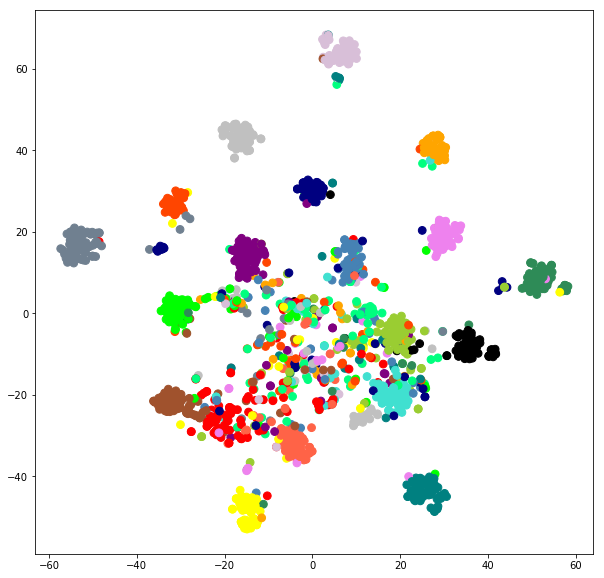

In [48]:
plot_tsne(T)

#### T-SNE embedding on LSA

In [49]:
%%time
L = tsne.fit_transform(LSA[:n_sample])

CPU times: user 36.7 s, sys: 2.86 s, total: 39.6 s
Wall time: 36.6 s


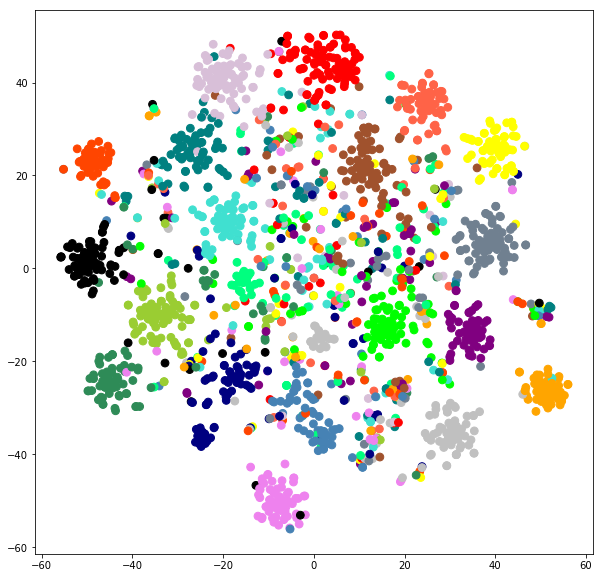

In [50]:
# matplotlib visualization
plot_tsne(L)

# Testing K-means on laplacian eigenvalues

In [51]:
%%time
NB = normalize(Y["le"])
km = KMeans(n_clusters=20, n_init=1)
km.fit(NB)
pred_labels = km.labels_
true_labels = y

# Evaluate clustering
cluster_quality(true_labels, pred_labels)

Homogeneity: 0.564
Completeness: 0.585
V-measure: 0.574
NMI: 0.574
Rand: 0.477
Acc: 0.649
CPU times: user 476 ms, sys: 14 ms, total: 490 ms
Wall time: 32.4 ms


In [52]:
%%time
LE = Y["le"]
TLE = tsne.fit_transform(LE[:n_sample])

CPU times: user 41.9 s, sys: 2.6 s, total: 44.5 s
Wall time: 39.4 s


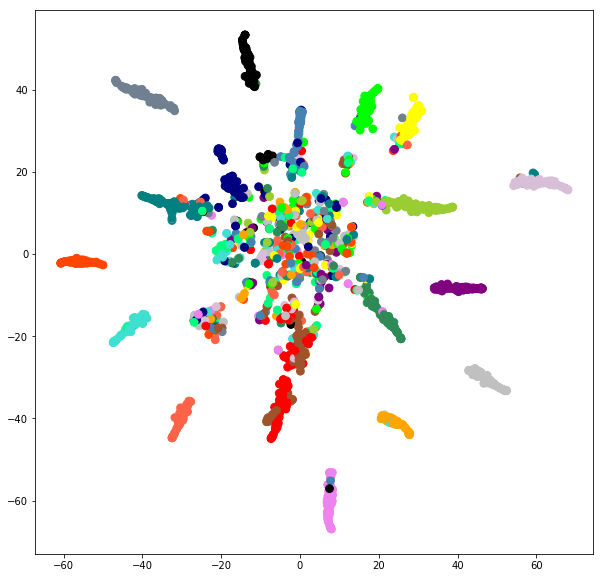

In [53]:
plot_tsne(TLE)